In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
housing = pd.read_csv("./datasets/housing/housing.csv")

In [96]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [97]:
housing['income_cat'] = pd.cut(housing.median_income, bins=[0.,1.5,3.0,4.5,6.,np.inf], labels=[1,2,3,4,5])

<AxesSubplot:>

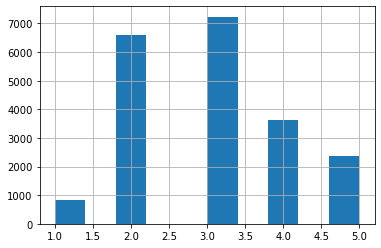

In [98]:
housing.income_cat.hist()

In [99]:
from sklearn.model_selection import StratifiedShuffleSplit

In [100]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [101]:
for train_index,test_index in split.split(housing, housing.income_cat):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

<AxesSubplot:>

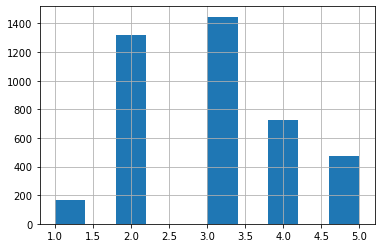

In [102]:
strat_test_set.income_cat.hist()

In [103]:
strat_test_set = strat_test_set.drop("income_cat",axis=1)

In [104]:
strat_train_set = strat_train_set.drop("income_cat",axis=1)

In [105]:
housing = strat_train_set.drop('median_house_value', axis=1)

In [106]:
housing_labels = strat_train_set.median_house_value.copy()

In [107]:
from sklearn.impute import SimpleImputer

In [108]:
imputer = SimpleImputer(strategy="median")

In [109]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [110]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [111]:
X = imputer.transform(housing_num)

In [112]:
housing_cat = housing[['ocean_proximity']]

In [113]:
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [114]:
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7277
INLAND             5262
NEAR OCEAN         2124
NEAR BAY           1847
ISLAND                2
dtype: int64

In [115]:
from sklearn.preprocessing import OrdinalEncoder

In [116]:
ordinal_encoder = OrdinalEncoder()

In [117]:
housing_encoded = orderinal_encoder.fit_transform(housing_cat)

In [118]:
housing_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [119]:
from sklearn.preprocessing import OneHotEncoder

In [120]:
cat_encoder = OneHotEncoder()

In [121]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [122]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [123]:
from sklearn.base import BaseEstimator, TransformerMixin

In [124]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

In [125]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:,households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedroom_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedroom_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [126]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

In [127]:
housing_extra_attribs = attr_adder.transform(housing.values)

In [128]:
housing.values[3]

array([-117.13, 32.75, 24.0, 1877.0, 519.0, 898.0, 483.0, 2.2264,
       'NEAR OCEAN'], dtype=object)

In [129]:
housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        3.1725888324873095]], dtype=object)

In [130]:
from sklearn.pipeline import Pipeline

In [131]:
from sklearn.preprocessing import StandardScaler

In [132]:
num_pipeline = Pipeline([("imputer", SimpleImputer(strategy="median")),
                        ("attribs_adder", CombinedAttributesAdder()),
                        ("std_scaler", StandardScaler())])

In [133]:
from sklearn.compose import ColumnTransformer

In [134]:
num_attribs = list(housing_num)

In [135]:
cat_attribs = ["ocean_proximity"]

In [136]:
full_pipeline = ColumnTransformer([ ("num", num_pipeline, num_attribs),
                                  ("cat", OneHotEncoder(), cat_attribs )])

In [137]:
housing_prepared = full_pipeline.fit_transform(housing)

In [138]:
from sklearn.linear_model import LinearRegression

In [139]:
lin_reg = LinearRegression()

In [140]:
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [141]:
some_data = housing.iloc[:5]

In [142]:
some_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


In [143]:
some_labels = housing_labels.iloc[:5]

In [144]:
some_labels

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
Name: median_house_value, dtype: float64

In [145]:
some_data_prepared = full_pipeline.transform(some_data)

In [146]:
some_data_prepared

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
         0.73260236,  0.55628602, -0.8936472 ,  0.01739526,  0.00622264,
        -0.12112176,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
         0.53361152,  0.72131799,  1.292168  ,  0.56925554, -0.04081077,
        -0.81086696,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, -0.46977281, -0.54513828,
        -0.67467519, -0.52440722, -0.52543365, -0.01802432, -0.07537122,
        -0.33827252,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.22173797, -1.35147437, -0.37006852, -0.34865152, -0.03636724,
        -0.46761716, -0.03729672, -0.86592882, -0.59513997, -0.10680295,
         0.96120521,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.43743108, -0.63581817, -0

In [147]:
pred = lin_reg.predict(some_data_prepared)

In [148]:
pred

array([ 85657.90192014, 305492.60737488, 152056.46122456, 186095.70946094,
       244550.67966089])

In [149]:
list(some_labels)

[72100.0, 279600.0, 82700.0, 112500.0, 238300.0]

In [150]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [151]:
housing_prediction = lin_reg.predict(housing_prepared)

In [158]:
lin_mse = mean_squared_error(housing_labels, housing_prediction)

In [159]:
lin_mse

4709785076.060029

In [154]:
housing_prediction[:3]

array([ 85657.90192014, 305492.60737488, 152056.46122456])

In [155]:
housing_labels[:3]

12655     72100.0
15502    279600.0
2908      82700.0
Name: median_house_value, dtype: float64

In [160]:
lin_rmse = np.sqrt(lin_mse)

In [161]:
lin_rmse

68627.87390018745

In [162]:
from sklearn.tree import DecisionTreeRegressor

In [163]:
tree_reg = DecisionTreeRegressor()

In [164]:
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [165]:
housing_predictions = tree_reg.predict(housing_prepared)

In [166]:
tree_mse = mean_squared_error(housing_labels, housing_predictions)

In [167]:
tree_rmse = np.sqrt(tree_mse)

In [168]:
tree_rmse

0.0

In [169]:
from sklearn.model_selection import cross_val_score

In [170]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv = 10)

In [171]:
tree_rmse_scores = np.sqrt(-scores)

In [173]:
def display_scores(scores):
    print("Scores :", scores)
    print("Mean :", scores.mean())
    print("Std Deviation :", scores.std())

In [175]:
display_scores(tree_rmse_scores)

Scores : [72589.38010756 71453.75714125 68185.68526303 70648.06168114
 71144.12996606 78650.75489146 71766.85100133 73234.49203361
 68359.23032838 71714.49789712]
Mean : 71774.68403109346
Std Deviation : 2763.9629135453565


In [176]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv = 10)

In [177]:
lin_rmse_scores = np.sqrt(-lin_scores)

In [178]:
display_scores(lin_rmse_scores)

Scores : [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean : 69104.07998247063
Std Deviation : 2880.3282098180607


In [179]:
from sklearn.ensemble import RandomForestRegressor

In [180]:
forest_reg = RandomForestRegressor()

In [181]:
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [189]:
housing_predictions = forest_reg.predict(housing_prepared)

In [190]:
forest_mse = mean_squared_error(housing_labels, housing_predictions)

In [191]:
forest_rmse = np.sqrt(forest_mse)

In [192]:
forest_rmse

18832.378295771337

In [193]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv = 10)

In [194]:
forest_rmse_scores = np.sqrt(-forest_scores)

In [195]:
display_scores(forest_rmse_scores)

Scores : [50925.54370671 48963.9539692  46902.71680912 52122.73767417
 47502.033564   52264.39288427 52339.85258989 49755.18400267
 48958.55645129 53830.89661267]
Mean : 50356.586826397805
Std Deviation : 2177.6177182402016
